<a href="https://colab.research.google.com/github/harshitayadavv/Spotify-Music-Recommender-/blob/main/Spotify_Recommendor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing

#### Importing the libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


#### Importing the dataset

In [13]:
df = pd.read_csv("dataset.csv")
df.head()


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4.0,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4.0,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4.0,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3.0,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4.0,acoustic


#### Handling Missing & Duplicate Values

In [14]:
df.isnull().sum()


,0
Unnamed: 0,0
track_id,0
artists,0
album_name,0
track_name,0
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


In [15]:
df.dropna(inplace=True)


In [16]:
df.isnull().sum()


,0
Unnamed: 0,0
track_id,0
artists,0
album_name,0
track_name,0
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


In [17]:
df.duplicated().sum()


np.int64(0)

#### Dropping irrelevant columns

In [18]:
df_original = df.copy()

df_clustering = df.drop(['track_id', 'track_name', 'album_name', 'artists'], axis=1)


#### Encoding categorical data

In [19]:
from sklearn.preprocessing import LabelEncoder

# Encode 'track_genre'
le_genre = LabelEncoder()
df_clustering['track_genre'] = le_genre.fit_transform(df_clustering['track_genre'])

if df_clustering['explicit'].dtype == 'object':
    df_clustering['explicit'] = df_clustering['explicit'].map({'False': 0, 'True': 1})


#### Feature Scaling

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)  # NOT df


## Model Development - K means Clustering

#### Elbow method to find no of clusters

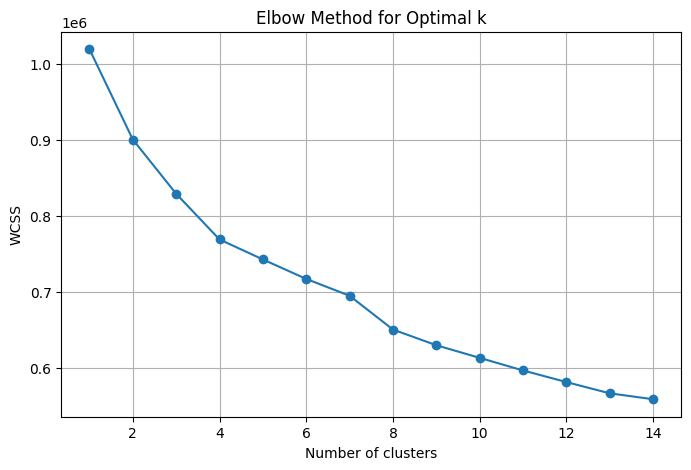

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal number of clusters
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


#### Building the model

In [24]:
# Train the KMeans model with 13 clusters
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
df['cluster'] = clusters

# Check distribution of songs in each cluster
print(df['cluster'].value_counts())


cluster
5    15083
4    12863
3    12505
1     7639
0     7214
2     3757
6      909
Name: count, dtype: int64


#### Visualising the clusters

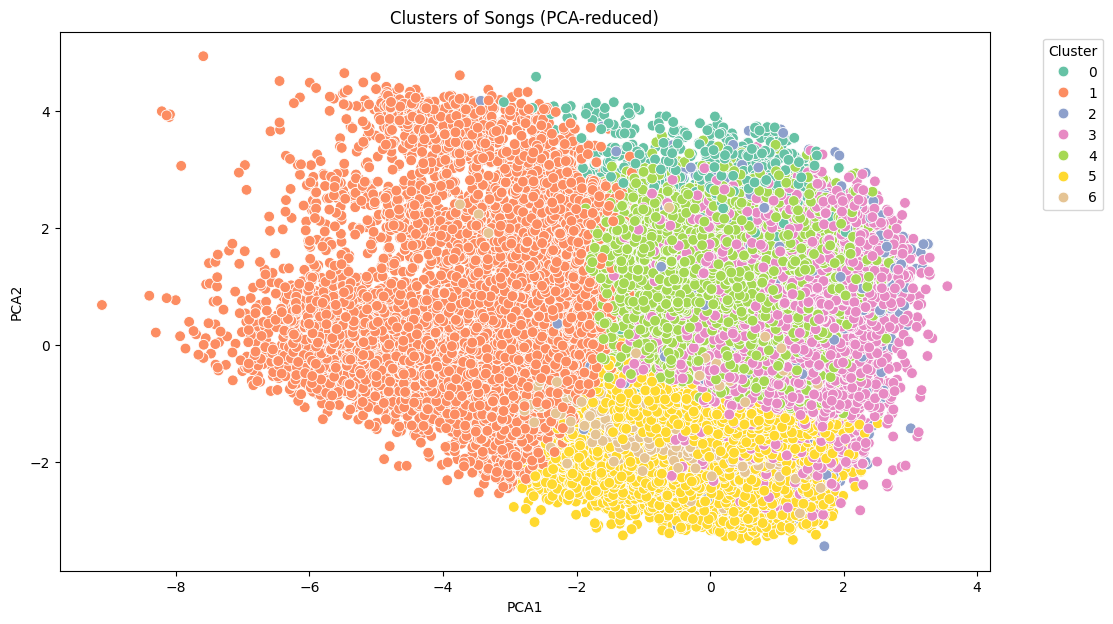

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame()
pca_df['PCA1'] = X_pca[:, 0]
pca_df['PCA2'] = X_pca[:, 1]
pca_df['Cluster'] = df['cluster']

# Plotting
plt.figure(figsize=(12, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=pca_df, s=60)
plt.title('Clusters of Songs (PCA-reduced)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Recommendation System

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_songs(song_name, df, features_scaled, n_recommendations=5):
    # Find the index of the song
    song_index = df[df['track_name'].str.lower() == song_name.lower()].index

    if len(song_index) == 0:
        return f"Song '{song_name}' not found in the dataset. Please check the name."

    song_index = song_index[0]

    # Get the cluster of that song
    song_cluster = df.loc[song_index, 'cluster']

    # Filter dataset to include only songs in the same cluster
    cluster_indices = df[df['cluster'] == song_cluster].index
    cluster_features = features_scaled[cluster_indices]

    # Compute cosine similarity between the input song and other songs in same cluster
    input_song_vector = features_scaled[song_index].reshape(1, -1)
    similarities = cosine_similarity(input_song_vector, cluster_features)[0]

    # Create a DataFrame with similarities
    cluster_df = df.loc[cluster_indices].copy()
    cluster_df['similarity'] = similarities

    # Sort by similarity and remove the input song itself
    recommendations = cluster_df.sort_values(by='similarity', ascending=False)
    recommendations = recommendations[recommendations['track_name'].str.lower() != song_name.lower()]

    return recommendations[['track_name', 'artists']].drop_duplicates().head(n_recommendations)

# 🎧 User-facing function
def get_song_recommendations():
    song_name = input("🎵 Enter a song you like: ")
    results = recommend_songs(song_name, df, X_scaled, n_recommendations=5)

    print("\n🎶 Recommended Songs:\n")
    print(results if isinstance(results, str) else results.to_string(index=False))

# 🔁 Run this function to use
get_song_recommendations()


🎵 Enter a song you like: Adore You

🎶 Recommended Songs:

                     track_name                              artists
            Roma (Lrdp Maqueta)                               Sabino
                   Chup Chup Ke Pritam;Shaan;Muazzam;Rizwan Ali Khan
Amo Você Quero Te Ter - Ao Vivo                  Solteirões do Forró
                     Sira E Hou             Amrit Maan;Nimrat Khaira
              Respeita Januário                         Luiz Gonzaga
